# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Этапы выполнения**

1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

**Описание данных**

Данные взяты с сайта **ChaLearn Looking at People**. Они находятся в папке `/datasets/faces/`. 
В вашем распоряжении одна папка со всеми изображениями`(/final_files)` и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age.` 
Извлечь данные из папки вам поможет новый метод **ImageDataGenerator** —`flow_from_dataframe(dataframe, directory, ...)`.

## Исследовательский анализ данных

***Импорт библиотек***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

**Загрузка датасета**

In [2]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except Exception as e:
    print(f'Ошибка при загрузке датасета: {e}')
else:
    print('Датасет успешно загружен.')
finally:
    print('Завершена попытка загрузки файлов.')

Датасет успешно загружен.
Завершена попытка загрузки файлов.


**Обзор датасета**

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Типы данных в порядке.

In [5]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

Отлично! Пропуски в данных отсутствуют.

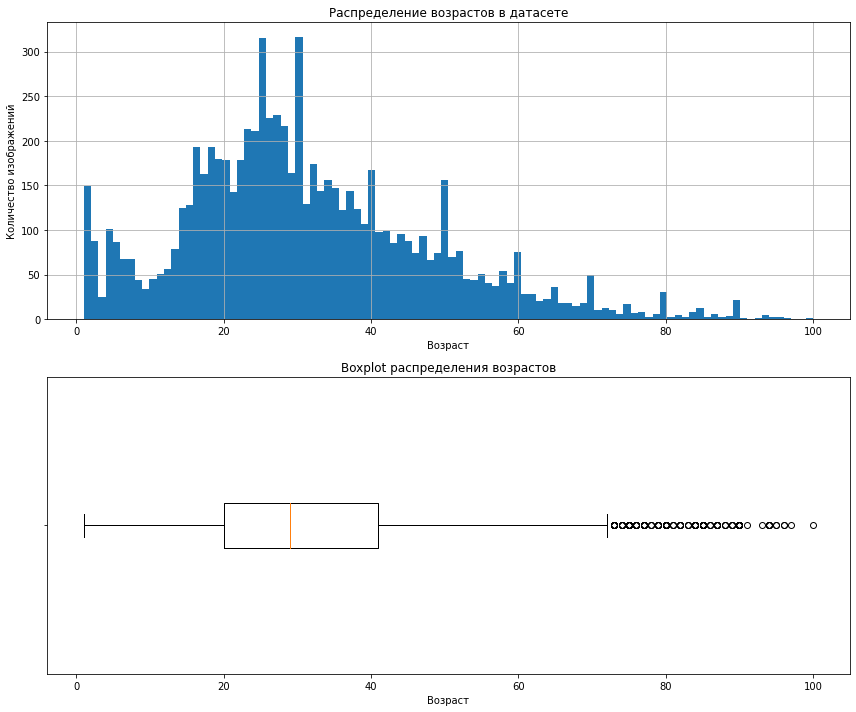

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 10))

labels.hist(bins=100, ax=axes[0])
axes[0].set_title('Распределение возрастов в датасете')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество изображений')

axes[1].boxplot(labels['real_age'], vert=False)
axes[1].set_title('Boxplot распределения возрастов')
axes[1].set_xlabel('Возраст')
axes[1].set_yticks([1])
axes[1].set_yticklabels([''])

plt.tight_layout()
plt.show()

Распределение возрастов на гистограмме показывает, что в датасете представлены значения от 0 до 100 лет, однако основная масса данных сосредоточена в диапазоне от 15 до 50 лет. Особенно заметны выраженные пики в районе 20, 30 и 35 лет. После 60 лет количество примеров заметно снижается, а после 80 — очень минимальна. Это говорит о том, что модель будет иметь хорошее качество предсказаний для молодых и взрослых людей, но может существенно ошибаться на пожилых из-за недостаточного количества примеров в этой возрастной группе.

Boxplot показывает, что оранжевая линия в середине ящика(медиана) находится примерно на уровне 30 лет. Это означает, что половина примеров в выборке младше 30 лет, а другая половина — старше. Сам ящик, охватывающий межквартильный размах (от 25-го до 75-го перцентиля), показывает, что большинство возрастов сконцентрированы в диапазоне примерно от 20 до 45 лет. Усы графика простираются от примерно 3 до 70 лет. Всё, что выше, отображается в виде отдельных точек над верхним усом — это статистические выбросы, которые начинаются примерно с 70 лет и доходят до 100. Эти значения соответствуют малому количеству пожилых людей в датасете, как и было видно по гистограмме: основной объём выборки — молодые и люди среднего возраста.

**Печать изображений**

Создание генератора и загрузка изображений и возрастов

In [7]:
datagen = ImageDataGenerator(rescale=1./255)  

generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    class_mode='raw',  
    batch_size=16,
    seed=12345
)

images, ages = next(generator)

Found 7591 validated image filenames.


Визуализаци первых 10 изображений

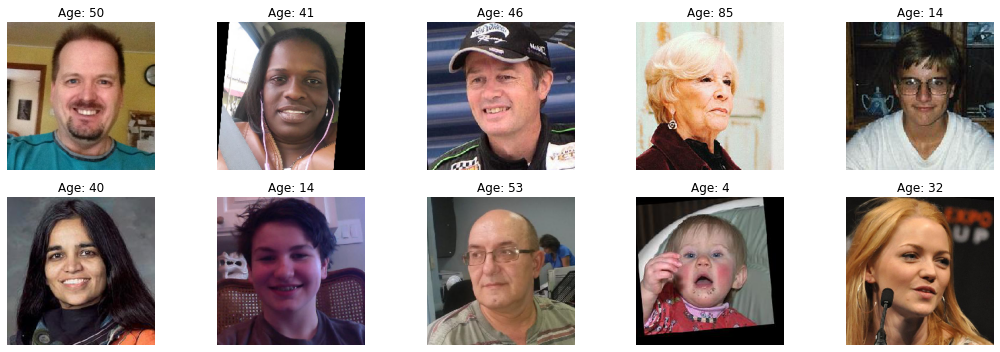

In [8]:
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {int(ages[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Визуально заявленные возроста соответствуют изображениям

**Промежуточный вывод**

**Размер и структура датасета:**

 - В датасете содержится 7591 изображение, каждое связано с реальным возрастом человека. 
 - Пропущенных значений нет — данные чистые и готовы к обработке.

**Распределение целевого признака (возраста):**

 - Возраст варьируется от 0 до 100 лет.

 - Основная часть данных сосредоточена в диапазоне 15–50 лет, медиана — около 30 лет.

 - После 60 лет количество изображений значительно снижается, что приведёт к меньшей точности предсказаний модели для пожилых людей.

**Анализ изображений:**

 - Все изображения квадратные и приведены к одному формату (224x224), что упрощает предобработку.

 - На фото — лица крупным планом, снятые под разными углами (фас, профиль, полуоборот).

 - Встречаются как цветные, так и черно-белые изображения.

 - Некоторые фото содержат артефакты: очки, жевательная резинка, предметы, перекрывающие лицо.

**Выводы для дальнейшей работы:**

 - Для улучшения качества модели стоит использовать аугментации, такие как: `rotation_range`, `horizontal_flip`, `zoom_range`.


Особенности данных (разные цвета, углы, повороты) подтверждают, что устойчивая архитектура вроде ResNet50 — разумный выбор.

## Обучение модели

**Код обучения**

```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25,
        rotation_range=20,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):

    optimizer = Adam(learning_rate=1e-4)

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model

```

**Результаты обучения**

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 139s - loss: 241.1347 - mae: 11.1386 - val_loss: 386.6704 - val_mae: 14.6681
Epoch 2/5
356/356 - 129s - loss: 101.5034 - mae: 7.6298 - val_loss: 149.5038 - val_mae: 9.2210
Epoch 3/5
356/356 - 129s - loss: 84.9314 - mae: 7.0134 - val_loss: 83.4227 - val_mae: 6.9783
Epoch 4/5
356/356 - 130s - loss: 71.4264 - mae: 6.4850 - val_loss: 109.8985 - val_mae: 7.3121
Epoch 5/5
356/356 - 128s - loss: 59.4550 - mae: 5.9049 - val_loss: 78.7115 - val_mae: 6.8132

119/119 - 13s - loss: 78.7115 - mae: 6.8132
```

## Анализ обученной модели

В ходе обучения использовалась модель `ResNet50` в качестве основы без верхнего классификационного слоя. Уже на второй эпохе наблюдалось значительное снижение ошибки, что говорит о быстрой адаптации модели к задаче. Финальная `MAE` на обучающей выборке составила **5.9 года**, а на валидационной — **6.81 года**. Это указывает на хорошее качество предсказаний. Основные трудности модель испытывает с возрастами, редко представленными в данных, особенно среди пожилых (70+). В целом, ResNet50 показала высокую эффективность при предсказании возраста.